# An example analytic query against a ***dimensional*** model's star schema vs. a ***nondimensional*** model

In [ ]:
from pandas import DataFrame
from data201 import db_connection, df_query

## Query against the dimensional model
#### How do the ***quantities of sold products*** in all categories on ***Wednesdays*** by vendor ***Pacifica Gear*** within the ***Chicagoland*** region during the ***first quarter*** of ***2023*** compare to the ***second quarter*** of ***2023***?
#### We analyze the `units_sold` measure of the `sales` fact table relative to the `calendar`, `store`, and `product` dimension tables.
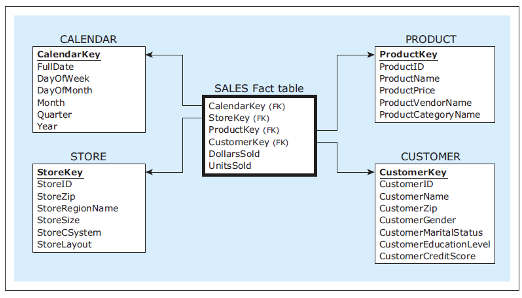

In [ ]:
conn_warehouse = db_connection(config_file = 'zagi-warehouse.ini')

df_query(conn_warehouse,
    """
    SELECT c.qtr AS quarter, 
           SUM(sa.units_sold) AS total_units_sold, 
           p.product_category_name,
           p.product_vendor_name, c.day_of_week
    
    FROM calendar c
    JOIN sales sa USING (calendar_key)
    JOIN store s USING (store_key)
    JOIN product p USING (product_key)
    WHERE p.product_vendor_name = 'Pacifica Gear'
      AND s.store_region_name   = 'Chicagoland'
      AND c.day_of_week = 'Wednesday'
      AND c.year        = 2023
      AND c.qtr IN (1, 2)
    
    GROUP BY p.product_category_name, 
             p.product_vendor_name,
             c.day_of_week, 
             c.qtr
    ORDER BY c.qtr
    """
)

## Query against the nondimensional model
#### How do the ***quantities of sold products*** in all categories on ***Wednesdays*** by vendor ***Pacifica Gear*** within the ***Chicagoland*** region during the ***first quarter*** of ***2023*** compare to the ***second quarter*** of ***2023***?
#### We must join seven tables: `region`, `store`, `sales_transaction`, `sold_via`, `product`, `vendor`, and `category`. We must call date-extraction functions: `QUARTER`, `DAYNAME`, and `YEAR` for each row of the result.
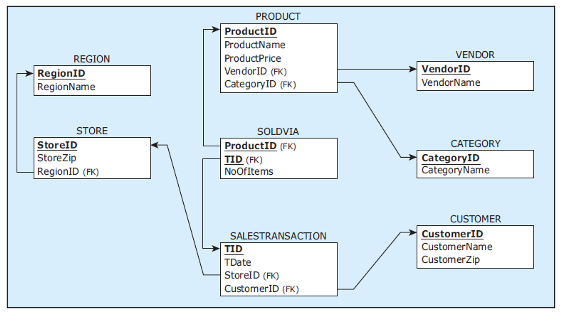

In [ ]:
conn_sales = db_connection(config_file = 'zagi-sales.ini')

df_query(conn_sales,
    """
    SELECT QUARTER(st.tdate) AS quarter, 
           SUM(sv.no_of_items) AS total_units_sold, 
           c.category_name, v.vendor_name,
           DAYNAME(st.tdate) AS day_of_week

    FROM region r
    JOIN store s USING (region_id)
    JOIN sales_transaction st USING (store_id)
    JOIN sold_via sv USING (tid)
    JOIN product p USING (product_id)
    JOIN vendor v USING (vendor_id)
    JOIN category c USING (category_id)
    
    WHERE v.vendor_name     = 'Pacifica Gear'
      AND r.region_name     = 'Chicagoland'
      AND DAYNAME(st.tdate) = 'Wednesday'
      AND YEAR(st.tdate)    = 2023
      AND QUARTER(st.tdate) IN (1, 2)

    GROUP BY c.category_name, 
             v.vendor_name,
             DAYNAME(st.tdate), 
             QUARTER(st.tdate)
    ORDER BY QUARTER(st.tdate)
    """
)

In [ ]:
conn_warehouse.close()
conn_sales.close()